In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

from joblib import dump, load

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


pd.options.display.max_rows = 10

In [131]:

def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
#     next_df = df.shift(1)
#     dist = haversine(df.iloc[:,0], df.iloc[:,1],
#                     next_df.iloc[:,0], next_df.iloc[:,1])
    locations = df[["longitude", "latitude"]]
    dist = spherical_dist(locations.values, locations.shift(-1).values)
    return dist

k = pi/180

def spherical_dist(pos1, pos2, r=6378.137):
    '''
    stackexchange 19413259
    '''
    pos1 = pos1 * k
    pos2 = pos2 * k
    cos_lat1 = cos(pos1[..., 1])
    cos_lat2 = cos(pos2[..., 1])
    cos_lat_d = cos(pos1[..., 1] - pos2[..., 1])
    cos_lon_d = cos(pos1[..., 0] - pos2[..., 0])
    return r * arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["time"] - next_df["time"]
    return timedelt

def compute_bearing(df):
    next_df = df.shift(1)
    bear = cal_bearing(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return bear

def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

def cal_bearing(lat1, lon1, lat2, lon2):
#     """
#     Calculates the bearing between two points using the formula
#         θ = atan2(sin(Δlong).cos(lat2),
#                   cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
#     """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

#     dLon = lon2 - lon1;
#     y = sin(dLon) * cos(lat2);
#     x = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(dLon);
#     brng = np.rad2deg(arctan2(y, x));
#     brng = (brng + 360) % 360
        
    return brng


def compute_bearing_diff(df):
    next_df = df.shift(1)
    bearing_diff = next_df["bearing"] - df["bearing"]
    return bearing_diff
#     df1 = df.copy()
#     df1["prev_bearing"] = df1["bearing"].shift(1)
#     df1["bearing diff"] = df1.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)
#     print(df1['bearing diff'])
#     return df1["bearing diff"]

def speed_diff(df):
    next_df = df.shift(1)
    diff = df - next_df
    return diff

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float))
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

In [3]:
df = pd.read_csv('/mnt/hgfs/FYP/all.tsv', delim_whitespace=True, header =None, parse_dates=[1])
df.columns = ['trip id','time','latitude','longitude']
grouper = df.groupby('trip id')

In [13]:
df = df[df['latitude'] < 37.85]
df = df[df['latitude'] > 37.70]
df = df[df['longitude'] < -122.35]


In [7]:
# tripid = df["trip id"].unique()
# tracks_dict = {elem: pd.DataFrame for elem in tripid}

In [ ]:
# for key in tqdm(tracks_dict.keys()):
#         tracks_dict[key] = df[:][df["trip id"] == key] # [:] equal to .loc[:, tracks["name"]]

In [4]:
c = []
for name, val in tqdm(grouper):
    c.append(val)


100%|██████████| 24999/24999 [00:07<00:00, 3250.78it/s]


In [5]:
def time_to_dest(df):
    end_time = df['time'].iloc[-1]
    df['time_to_dest'] = (end_time - df['time']).dt.total_seconds().astype(int)
def set_dropoff(df):
    df['dropoff_latitude'] = df['latitude'].iloc[-1]
    df['dropoff_longitude'] = df['longitude'].iloc[-1]


In [6]:
import tensorflow as tf
from tensorflow.python.keras.backend import tanh, conv1d, expand_dims, squeeze, clip
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Flatten, Conv1D, Conv2D, Lambda, concatenate, Reshape, TimeDistributed, MaxPooling1D, Permute, BatchNormalization, ELU
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import losses
# from tensorflow.python.keras.activations import elu


import tensorflow.python.keras.backend as K


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
from tensorflow.python.keras import backend as K
# import tensorflow as tf
def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))
def rmsletf(y_pred, y_true): 
    y_pred= tf.cast(y_pred, tf.float64) 
    y_true= tf.cast(y_true, tf.float64) 
    y_pred=tf.nn.relu(y_pred) 
    return np.abs(tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true)))))

In [10]:
bad_idx = []
for i, d in enumerate(c):
    if len(d) < 40:
        bad_idx.append(i)
c = [i for j, i in enumerate(c) if j not in bad_idx]


In [ ]:
counter = 0
for i in c:
    i.plot('longitude', 'latitude', kind = 'scatter', figsize = (16,9))
    counter += 1
    if counter > 5:
        break

In [8]:
def coord_pca(taxi):
    coords = np.vstack((taxi[['pickup_latitude', 'pickup_longitude']].values,
                        taxi[['dropoff_latitude', 'dropoff_longitude']].values))
    pca = PCA()
    pca = pca.fit(coords)
    taxi['pickup_pca0'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 0]
    taxi['pickup_pca1'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 1]
    taxi['dropoff_pca0'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    taxi['dropoff_pca1'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [13]:
km = KMeans(
    n_clusters=10, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
coordinates = pd.concat(c)[["longitude", "latitude"]].sample(10000).values
km.fit(coordinates)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [9]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.latitude).abs()
    
    #the Haversine version
    foob = df[["latitude", "longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
    df['hav_dist_lat'] = haversine(foob.iloc[:,0], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,1])
    df['hav_dist_lon'] = haversine(foob.iloc[:,2], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,3])
    
    
def convert_km(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*80.4
    df['abs_diff_latitude'] = df.abs_diff_latitude*111

In [68]:
%load_ext line_profiler

In [74]:
def derive_features():
    df2 = compute_speed(c[1])
    time_to_dest(df2)
    set_dropoff(df2)
    add_travel_vector_features(df2)
    convert_km(df2)
    df2['Euclidean'] = (df2.abs_diff_latitude**2 + df2.abs_diff_longitude**2)**0.5 
    
    df2['manh_length_hav'] = df2.hav_dist_lat + df2.hav_dist_lon
    df2['manh_length_euc'] = df2.abs_diff_latitude + df2.abs_diff_longitude
    
    df2['minkowski_0.9'] = (df2.hav_dist_lat**0.92 + df2.hav_dist_lon**0.92)**(1/0.92)
    df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)
    df2['pickup_weekday'] = df2['time'].dt.weekday
    df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
    df2['pickup_hour'] = df2['time'].dt.hour
    df2['pickup_minute'] = df2['time'].dt.minute
    df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
    df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']
#     df2[['next_lat', 'next_lon']] = df2[['latitude', 'longitude']].shift(-5)
    
    coordinates = df2[['latitude', 'longitude']]
    pickup_km = km.predict(coordinates)
    df2["pickup_cluster"] = pickup_km
    
    coordinates = df2[['dropoff_latitude', 'dropoff_longitude']]
    dropoff_km = km.predict(coordinates)
    df2["dropoff_cluster"] = dropoff_km

In [110]:
%lprun -f spherical_dist spherical_dist(locations.values, locations.shift(-1).values)

Timer unit: 1e-06 s

Total time: 5.1e-05 s
File: <ipython-input-105-239816e1b144>
Function: spherical_dist at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                           def spherical_dist(pos1, pos2, r=6378.137):
    22                                               '''
    23                                               stackexchange 19413259
    24                                               '''
    25         1          8.0      8.0     15.7      pos1 = pos1 * k
    26         1          2.0      2.0      3.9      pos2 = pos2 * k
    27         1          5.0      5.0      9.8      cos_lat1 = cos(pos1[..., 1])
    28         1          2.0      2.0      3.9      cos_lat2 = cos(pos2[..., 1])
    29         1          5.0      5.0      9.8      cos_lat_d = cos(pos1[..., 1] - pos2[..., 1])
    30         1          3.0      3.0      5.9      cos_lon_d = cos(pos1[..., 0] - pos2[..., 0])
    31         1         26.0     26.

In [ ]:
%lprun -f haversine haversine(c[1]['latitude'], c[1]['longitude'], c[1]['latitude'].shift(-1), c[1]['longitude'].shift(-1))

In [132]:
%lprun -f compute_speed compute_speed(c[1])

Timer unit: 1e-06 s

Total time: 0.041914 s
File: <ipython-input-131-131d1de8142a>
Function: compute_speed at line 119

Line #      Hits         Time  Per Hit   % Time  Line Contents
   119                                           def compute_speed(df):
   120         1        683.0    683.0      1.6      kinematics = df.copy()
   121         1       6373.0   6373.0     15.2      kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float))
   122         1       6498.0   6498.0     15.5      kinematics["time_elapsed"] = compute_time(kinematics).values
   123         1       2427.0   2427.0      5.8      kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
   124         1       2355.0   2355.0      5.6      kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
   125         1       2041.0   2041.0      4.9      kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
 

In [126]:
%lprun -f derive_features derive_features()

Timer unit: 1e-06 s

Total time: 0.119241 s
File: <ipython-input-74-c8d169deb9c5>
Function: derive_features at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def derive_features():
     2         1      45521.0  45521.0     38.2      df2 = compute_speed(c[1])
     3         1       3358.0   3358.0      2.8      time_to_dest(df2)
     4         1       3659.0   3659.0      3.1      set_dropoff(df2)
     5         1      28709.0  28709.0     24.1      add_travel_vector_features(df2)
     6         1       2743.0   2743.0      2.3      convert_km(df2)
     7         1       3143.0   3143.0      2.6      df2['Euclidean'] = (df2.abs_diff_latitude**2 + df2.abs_diff_longitude**2)**0.5 
     8                                               
     9         1       1843.0   1843.0      1.5      df2['manh_length_hav'] = df2.hav_dist_lat + df2.hav_dist_lon
    10         1       2115.0   2115.0      1.8      df2['manh_length_e

In [ ]:
d = []
for i, df in tqdm(enumerate(c)):
    df2 = compute_speed(c[i])
    time_to_dest(df2)
    set_dropoff(df2)
    add_travel_vector_features(df2)
    convert_km(df2)
    df2['Euclidean'] = (df2.abs_diff_latitude**2 + df2.abs_diff_longitude**2)**0.5 
    
    df2['manh_length_hav'] = df2.hav_dist_lat + df2.hav_dist_lon
    df2['manh_length_euc'] = df2.abs_diff_latitude + df2.abs_diff_longitude
    
    df2['minkowski_0.9'] = (df2.hav_dist_lat**0.92 + df2.hav_dist_lon**0.92)**(1/0.92)
    df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)
    df2['pickup_weekday'] = df2['time'].dt.weekday
    df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
    df2['pickup_hour'] = df2['time'].dt.hour
    df2['pickup_minute'] = df2['time'].dt.minute
    df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
    df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']
#     df2[['next_lat', 'next_lon']] = df2[['latitude', 'longitude']].shift(-5)
    
    coordinates = df2[['latitude', 'longitude']]
    pickup_km = km.predict(coordinates)
    df2["pickup_cluster"] = pickup_km
    
    coordinates = df2[['dropoff_latitude', 'dropoff_longitude']]
    dropoff_km = km.predict(coordinates)
    df2["dropoff_cluster"] = dropoff_km
    
#     df2['duration'] = df2['dropoff_datetime'] - df2['pickup_datetime']
#     df2['duration'] = df2['duration'].dt.total_seconds().astype(int)
#     df2 = df[df2['duration'] > 0]
#     df2 = df2[df2['duration'] < 1000]
#     df2 = df2[df2.loc[:, 'direct_distance'] < 100] #100km

#     df2 = df2[df2.loc[:, 'duration'] > 120] #2 minutes
#     df2 = df2[df2.loc[:, 'direct_distance'] > 0.1] #100m

    d.append(df2)
    if i%500 == 0:
        print(i)
    if i > 10000:
        break

In [16]:
# for i in d:
#     i.dropna(inplace = True)

In [144]:
import random
random.shuffle(d)
mu, sigma = 0, 5

In [145]:
for df in d:
    df.replace([np.inf, -np.inf], 0.0, inplace = True)


In [146]:
x_data = []
y_data = []
for i in d:
    i = i[i['time_to_dest'] > 0] 
    x_data.append(i.drop(['time', 'trip id', 'time_elapsed_seconds', 'time_to_dest'] ,axis =1))
    noise = np.random.normal(mu, sigma, [len(i),1]) 
    y_data.append(i[['time_to_dest']] + abs(noise))
#     y_data.append(i[['next_lat', 'next_lon']])

In [21]:
x_data[1]

,latitude,longitude,distance_travelled,speed m/s,speed kmh,bearing,bearing_diff,rate_of_turn,acceleration,dropoff_latitude,...,minkowski_0.9,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster
221659,37.599956,-122.382563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.605999,...,0.940995,0.708633,5,1,0,48,0.0,120,3,3
221660,37.599943,-122.382504,0.005401,1.350281,4.861013,285.541474,0.000000,0.000000,0.000000,37.605999,...,0.948317,0.711656,5,1,0,48,4.0,120,3,3
221661,37.599921,-122.382451,0.005277,0.659644,2.374718,297.650820,12.109346,1.513668,-0.086330,37.605999,...,0.956070,0.715483,5,1,0,48,12.0,120,3,3
221662,37.599976,-122.382438,0.006229,1.557251,5.606104,190.606850,107.043970,26.760993,0.224402,37.605999,...,0.951058,0.710073,5,1,0,48,16.0,120,3,3
221663,37.600060,-122.382568,0.014795,3.698810,13.315716,129.199020,61.407831,15.351958,0.535390,37.605999,...,0.928606,0.697511,5,1,0,49,20.0,120,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221785,37.603843,-122.381867,0.072775,18.193756,65.497521,132.539468,3.127394,0.781848,0.132188,37.605999,...,0.556560,0.371948,5,1,1,16,1696.0,121,3,3
221786,37.604272,-122.382473,0.071673,17.918166,64.505396,131.782558,0.756910,0.189228,-0.068898,37.605999,...,0.449082,0.300310,5,1,1,17,1700.0,121,3,3
221787,37.604679,-122.383082,0.070266,17.566613,63.239808,130.149668,1.632890,0.408222,-0.087888,37.605999,...,0.343946,0.230045,5,1,1,17,1704.0,121,3,3
221788,37.605098,-122.383719,0.073017,18.254318,65.715544,129.701625,0.448043,0.112011,0.171926,37.605999,...,0.234776,0.157028,5,1,1,17,1708.0,121,3,3


In [50]:
pd.set_option('display.max_columns', 30)

In [51]:
 [item for item in x_data if np.any(np.isinf(item))]

[]

In [147]:
x_train = x_data[0:8900]
x_test = x_data[8900:]
y_train = y_data[0:8900]
y_test = y_data[8900:]

In [148]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
# scy = sklearn.preprocessing.MaxAbsScaler()
sc = sklearn.preprocessing.RobustScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

sc.fit(pd.concat(x_train).values)
scy.fit(pd.concat(y_train).values)


MinMaxScaler(copy=True, feature_range=(-1, 1))

In [149]:
bad_idx = []
for i, data in enumerate(x_train):
    try:
        x_train[i] = sc.transform(data)
    except:
        bad_idx.append(i)
    
for i, data in enumerate(y_train):
    try:
        y_train[i] = scy.transform(data)
    except:
        pass

In [150]:
x_train = [i for j, i in enumerate(x_train) if j not in bad_idx]
y_train = [i for j, i in enumerate(y_train) if j not in bad_idx]


In [151]:
x_test = sc.transform(pd.concat(x_test).values)
y_test = scy.transform(pd.concat(y_test).values)
# y_test = pd.concat(y_test).values

In [152]:
x_train[1][12:15,0:2]

array([[-0.09644716,  0.32104737],
       [-0.10060279,  0.31625025],
       [-0.10430176,  0.31209274]])

In [153]:
def batch_generator_multi(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        cnn_x_shape = (batch_size, sequence_length, 2)
        cnn_x_batch = np.zeros(shape=cnn_x_shape, dtype=np.float16)
        aux_x_shape = (batch_size, sequence_length, 26)
        aux_x_batch = np.zeros(shape=aux_x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.

            cnn_x_batch[i] = x_train[j][idx:idx+sequence_length, 0:2]
            aux_x_batch[i] = x_train[j][idx:idx+sequence_length, 2:]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield [cnn_x_batch, aux_x_batch], y_batch

In [154]:
short_idx = []
for i, data in enumerate(x_train):
    if len(x_train[i]) < 40:
        short_idx.append(i)
x_train = [i for j, i in enumerate(x_train) if j not in short_idx]
y_train = [i for j, i in enumerate(y_train) if j not in short_idx]

In [155]:
x_len = []
for i, data in enumerate(x_train):
    x_len.append(len(x_train[i]))
    

In [ ]:
for column in x_data[1]:
    plt.hist(pd.concat(x_data)[column][0:100000].values)
    plt.title(column)
    plt.show()


(array([343., 274.,   0., 238.,   0., 254., 278.,   0., 237.,   0., 255.,
        253.,   0., 216.,   0., 217., 214.,   0., 196.,   0., 177.,   0.,
        183., 169.,   0., 165.,   0., 169., 157.,   0., 145.,   0., 156.,
        137.,   0., 149.,   0., 150., 134.,   0., 127.,   0., 124.,   0.,
        112., 114.,   0., 106.,   0., 103.,  89.,   0.,  92.,   0., 124.,
         96.,   0.,  76.,   0.,  72.,   0.,  91.,  78.,   0.,  77.,   0.,
         75.,  66.,   0.,  64.,   0.,  71.,  68.,   0.,  61.,   0.,  71.,
         62.,   0.,  50.,   0.,  48.,   0.,  53.,  49.,   0.,  43.,   0.,
         43.,  56.,   0.,  44.,   0.,  46.,  35.,   0.,  39.,   0.,  41.,
         30.]),
 array([40.  , 40.59, 41.18, 41.77, 42.36, 42.95, 43.54, 44.13, 44.72,
        45.31, 45.9 , 46.49, 47.08, 47.67, 48.26, 48.85, 49.44, 50.03,
        50.62, 51.21, 51.8 , 52.39, 52.98, 53.57, 54.16, 54.75, 55.34,
        55.93, 56.52, 57.11, 57.7 , 58.29, 58.88, 59.47, 60.06, 60.65,
        61.24, 61.83, 62.42, 63.01

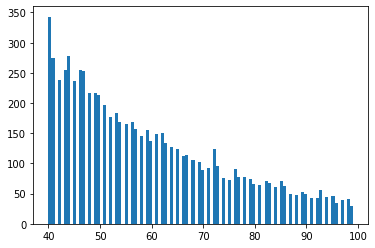

In [156]:
plt.hist(np.array(x_len)[np.array(x_len) < 100], bins = 100)

In [157]:
batch_size = 256
sequence_length = 35

In [158]:
generator = batch_generator_multi(batch_size=batch_size, sequence_length=sequence_length)
cnnx_batch, y_batch = next(generator)

In [159]:
cnnx_batch[0].shape

(256, 35, 2)

In [160]:
validation_data = ([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)],
                   np.expand_dims(y_test, axis=0))

In [161]:
validation_data[0][0].shape

(1, 74793, 2)

In [37]:
validation_data[1]

array([[[-0.82162915],
        [-0.82529398],
        [-0.82810741],
        ...,
        [-0.99333922],
        [-0.99674832],
        [-0.99846545]]])

In [162]:
cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
# CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
# CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
CNN_out = (TimeDistributed(Conv1D(16, (20), activation='elu', padding='same')))(CNN_out)
CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(1), strides=None, padding='valid')))(CNN_out)
# CNN_out = Permute(dims = (2,3,1))(CNN_out)
CNN_out = (TimeDistributed(Flatten()))(CNN_out)
# CNN_out = (TimeDistributed(Dense(4)))(CNN_out)
# CNN_out = Permute(dims = (2,1))(CNN_out)
# CNN_out = (Lambda(lambda x: squeeze(x, -1)))(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [163]:
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (InputLayer)       [(None, None, 2)]         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2, 1)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2, 8)        16        
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2, 16)       2576      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 2, 16)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 32)          0         
Total params: 2,592
Trainable params: 2,592
Non-trainable params: 0
_________________________________________________________

In [40]:
def layer_clip(input, maxx, minn):
    return K.clip(input, minn, maxx)

In [164]:
auxiliary_input = Input(shape=(None,26), name='aux_input')
x = concatenate([CNN_out, auxiliary_input], axis = 2)

In [165]:
x = GRU(80, return_sequences = True, activation = 'tanh')(x)
x = Dropout(0.05)(x)
# x = GRU(38,return_sequences = True, activation = 'tanh')(x)
# x = GRU(24,return_sequences = True, activation = 'elu')(x)
# x = Dropout(0.1)(x)
# x = Dropout(0.2)(x)
main_output = Dense(1, name='main_output')(x)
model = Model(inputs=[cnn_input, auxiliary_input], outputs=[main_output])


In [166]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [167]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 2, 1)   0           cnn_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, None, 2, 8)   16          lambda_1[0][0]                   
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, None, 2, 16)  2576        time_distributed_4[0][0]         
____________________________________________________________________________________________

In [75]:
from IPython.display import SVG
from tensorflow.python.keras.utils import model_to_dot

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [168]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [169]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

0.05
0.1
0.2
Epoch 00041: early stopping
0.3
Epoch 00043: early stopping
0.4
Epoch 00047: early stopping


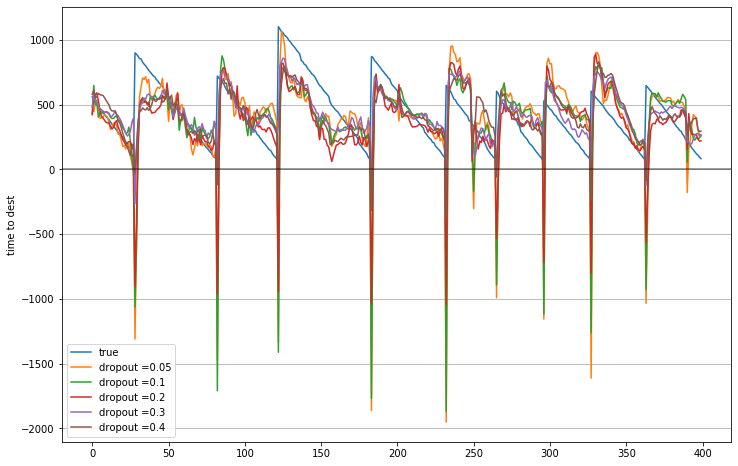

In [540]:
# batch_size = [40,80,120]
num_units = [18,19,20,21,22]
drop_rate = [0.05,0.1,0.2,0.3, 0.4]
plt.figure(figsize=(12, 8))
plt.plot(y_test_rescaled[1100:1500], label = 'true')
for i, j in enumerate(drop_rate):
    print(j)
    generator = batch_generator_multi(batch_size=batch_size, sequence_length=sequence_length)
    
    path_checkpoint = '23_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                          monitor='val_loss',
                                          verbose=0,
                                          save_weights_only=True,
                                          save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss',
                                            patience=5, verbose=1)
    callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                       histogram_freq=0,
                                       write_graph=False)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.1,
                                           min_lr=1e-4,
                                           patience=0,
                                           verbose=0)

    callbacks = [callback_early_stopping,
                 callback_checkpoint,
                 callback_tensorboard,
                 callback_reduce_lr]
    
    cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
    CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
    CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
    # CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
    # CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
    CNN_out = (TimeDistributed(Conv1D(16, (20), activation='elu', padding='same')))(CNN_out)
    CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(1), strides=None, padding='valid')))(CNN_out)
    # CNN_out = Permute(dims = (2,3,1))(CNN_out)
    CNN_out = (TimeDistributed(Flatten()))(CNN_out)
    
    auxiliary_input = Input(shape=(None,26), name='aux_input')
    x = concatenate([CNN_out, auxiliary_input], axis = 2)

    aux_input = Input(shape=(None,26), name='aux_input')
    x = GRU(60, return_sequences = True, activation = 'tanh')(aux_input)
    x = Dropout(j)(x)
#     x = GRU(20,return_sequences = True, activation = 'tanh')(x)
    main_output = Dense(1, name='main_output')(x)

    model = Model(inputs= [cnn_input, aux_input], outputs=[main_output])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    model.fit_generator(generator=generator,
                        epochs=50,
                        steps_per_epoch=50,
                        validation_data=validation_data,
                        callbacks=callbacks,
                       verbose = 0)
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)
#     y_pred = model.predict(np.expand_dims(x_test, axis =0))
    y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])

    y_pred_rescaled = scy.inverse_transform(y_pred[0])
    y_test_rescaled = scy.inverse_transform(y_test)

#     plt.figure(figsize=(12, 8))
    plt.ylabel('time to dest')
    # plt.plot(y_pred_rescaled, label = 'pred')
    # plt.plot(y_test_rescaled, label = 'true')
    plt.plot(y_pred_rescaled[1100:1500], label = 'dropout =' + str(j))

#     plt.plot(y_test_rescaled[1400:2000], label = 'true')
#     plt.legend()
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend() 
plt.show()

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.1443 - mean_absolute_error: 0.1443
Epoch 00001: val_loss improved from inf to 0.03637, saving model to 23_checkpoint.keras
200/200 [==============================] - 32s 161ms/step - loss: 0.1438 - mean_absolute_error: 0.1438 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 00002: val_loss improved from 0.03637 to 0.02597, saving model to 23_checkpoint.keras
200/200 [==============================] - 29s 146ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00003: val_loss improved from 0.02597 to 0.02183, saving model to 23_checkpoint.keras
200/200 [==============================] - 30s 152ms/step - loss: 0.0316 - mean_absolute_error:

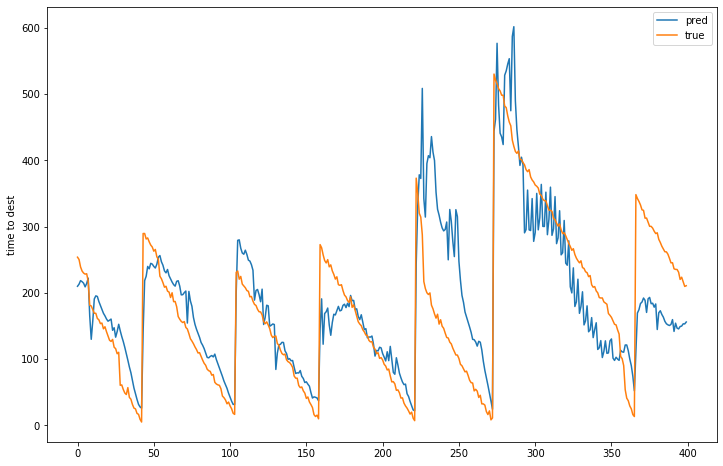

In [170]:
model.fit_generator(generator=generator,
                    epochs=50,
                    steps_per_epoch=200,
                    validation_data=validation_data,
                    callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
# y_pred = model.predict(np.expand_dims(x_test, axis =0))
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])
# y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test, axis =0)])

y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[1100:1500], label = 'pred')
plt.plot(y_test_rescaled[1100:1500], label = 'true')
plt.legend()

In [180]:
model.save('cnnrnn_160920_SF')

In [181]:
dump(km, 'km_160920_SF.joblib')
dump(sc, 'sc_160920_SF.joblib')
dump(scy, 'scy_160920_SF.joblib')

['scy_160920_SF.joblib']

In [559]:
model = []

In [45]:
model = tf.keras.models.load_model('cnnrnn_150920_SF')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [999]:
import gc
gc.collect()

4651

In [1153]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [171]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])


In [172]:
y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

In [173]:
y_pred[0][y_pred[0]> 1]

array([], dtype=float32)

In [ ]:
scy.inverse_transform(y_pred[0][y_pred[0] < -1].reshape(1,-1))

In [50]:
y_pred

array([[[-0.88083434],
        [-0.8710713 ],
        [-0.8661189 ],
        ...,
        [-0.99137723],
        [-0.9940189 ],
        [-0.9969157 ]]], dtype=float32)

In [51]:
y_pred_rescaled 

array([[465.11    ],
       [502.88797 ],
       [522.0511  ],
       ...,
       [ 37.36655 ],
       [ 27.144632],
       [ 15.935579]], dtype=float32)

In [52]:
y_test_rescaled 

array([[694.20323104],
       [680.02226221],
       [669.13574995],
       ...,
       [ 29.7746701 ],
       [ 16.58323992],
       [  9.9388379 ]])

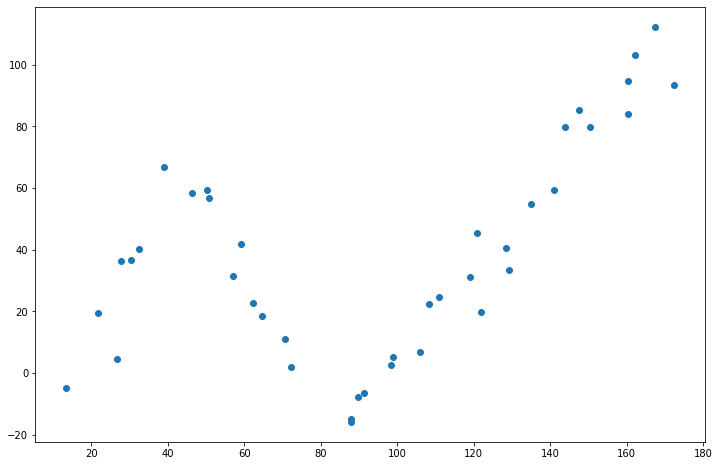

In [175]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test_rescaled[120:160] , y_pred_rescaled[120:160])


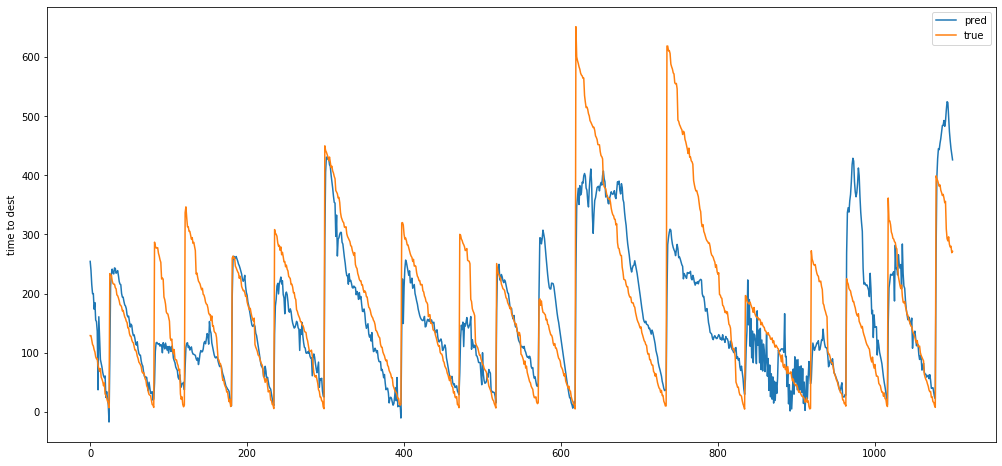

In [179]:
plt.figure(figsize=(17, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[4400:5500], label = 'pred')
plt.plot(y_test_rescaled[4400:5500], label = 'true')
plt.legend()

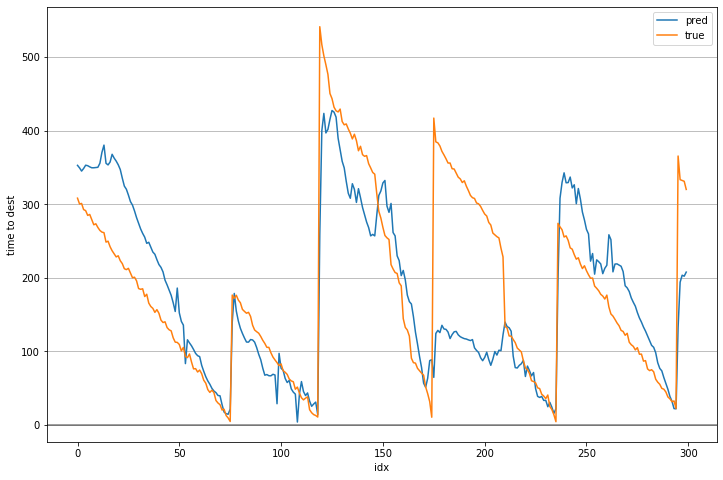

In [177]:
plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
plt.xlabel('idx')

plt.plot(y_pred_rescaled[1650:1950], label = 'pred')
plt.plot(y_test_rescaled[1650:1950], label = 'true')
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend()

In [13]:
from feature_builder import derive_features

In [ ]:
km = load('km_090920.joblib')
sc = load('sc_090920.joblib')
scy = load('scy_090920.joblib')
model = tf.keras.models.load_model('cnnrnn_090920')

In [11]:
km = load('Model_160920/km_160920_SF.joblib')
sc = load('Model_160920/sc_160920_SF.joblib')
scy = load('Model_160920/scy_160920_SF.joblib')
model = tf.keras.models.load_model('Model_160920/cnnrnn_160920_SF')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [76]:
hie = c[6][['latitude', 'longitude']].iloc[-1]

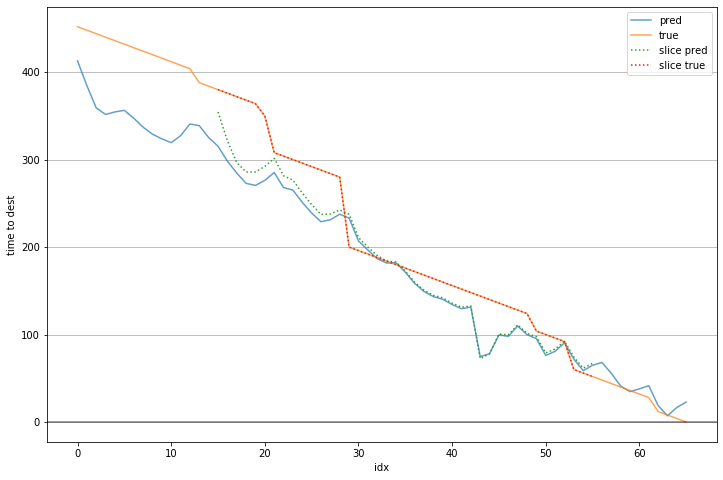

In [67]:
import sys, importlib
importlib.reload(sys.modules['feature_builder'])
from feature_builder import derive_features

i = 53
goog = derive_features(c[i], km, None)
# goog = goog[0:20]

end = len(c[i])
goog2 = derive_features(c[i][15:end-10], km, c[i][['latitude', 'longitude', 'time']].iloc[-1])

goog_true = goog['time_to_dest'].values
goog_true2 = goog2['time_to_dest'].values

goog = goog.drop(['time', 'trip id','time_elapsed_seconds', 'time_to_dest'],axis = 1 )
goog2 = goog2.drop(['time', 'trip id', 'time_elapsed_seconds', 'time_to_dest'],axis = 1 )

# goog = goog.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest', 'next_lat', 'next_lon'] ,axis =1)
# goog2 = goog2.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest', 'next_lat', 'next_lon'] ,axis =1)


goog = sc.transform(goog.values)
goog2 = sc.transform(goog2.values)

goog_pred = model.predict([np.expand_dims(goog[:,0:2], axis=0), np.expand_dims(goog[:,2:], axis =0)])
goog_pred2 = model.predict([np.expand_dims(goog2[:,0:2], axis=0), np.expand_dims(goog2[:,2:], axis =0)])


goog_pred = scy.inverse_transform(goog_pred[0])
goog_pred2 = scy.inverse_transform(goog_pred2[0])


plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
plt.xlabel('idx')

x_data = range(end)

plt.plot(x_data, goog_pred, label = 'pred', alpha=0.7)
plt.plot(x_data, goog_true, label = 'true', alpha=0.7)

plt.plot(x_data[15:end-10], goog_pred2, label = 'slice pred', linestyle=":")
plt.plot(x_data[15:end-10], goog_true2, label = 'slice true', linestyle=":")

plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend()

In [36]:
from sklearn.metrics import mean_absolute_error
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

count = 0
i = 98
p = len(c[i])
err_df = []

goog = derive_features(c[i], km, None)
goog_true = goog['time_to_dest'].values
goog = goog.drop(['time', 'trip id','time_elapsed_seconds', 'time_to_dest'],axis = 1 )
goog = sc.transform(goog.values)
goog_pred = model.predict([np.expand_dims(goog[:,0:2], axis=0), np.expand_dims(goog[:,2:], axis =0)])
goog_pred = scy.inverse_transform(goog_pred[0])

for k in tqdm(range(p)):
    for j in range(p):
        if (j - k) < 3:
            continue
        goog2 = derive_features(c[i][k:j], km, c[i][['latitude', 'longitude', 'time']].iloc[-1])
        goog_true2 = goog2['time_to_dest'].values
        goog2 = goog2.drop(['time', 'trip id', 'time_elapsed_seconds', 'time_to_dest'],axis = 1 )
        goog2 = sc.transform(goog2.values)
        goog_pred2 = model.predict([np.expand_dims(goog2[:,0:2], axis=0), np.expand_dims(goog2[:,2:], axis =0)])
        goog_pred2 = scy.inverse_transform(goog_pred2[0])
        err = mean_absolute_error(goog_pred2, goog_true2)
        err_df.append(err)


100%|██████████| 37/37 [03:10<00:00,  5.14s/it]


In [44]:
idx_list = []
for k in tqdm(range(p)):
    for j in range(p):
        if (j - k) < 3:
            continue
        idx_list.append((k,j))

100%|██████████| 37/37 [00:00<00:00, 38508.50it/s]


In [47]:
err_df2 = pd.DataFrame(err_df, index = idx_list)

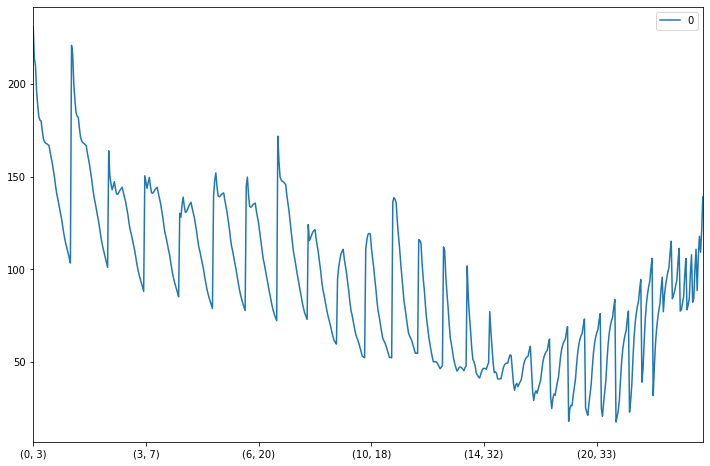

In [53]:
err_df2.plot(figsize= (12,8))

In [55]:
diffs = []
for ele in idx_list:
    diffs.append(abs(ele[0] - ele[1]))

In [56]:
err_df2['col2'] = diffs

In [58]:
grouper = err_df2.groupby('col2')

In [65]:
for q,w in grouper:
    print(w[0].mean())

96.28934493719365
94.56259455825344
94.36035633087158
94.32589820123489
94.6674025762649
95.01545629830196
95.23658056107777
94.93869939733433
94.09455380739867
93.7254549153646
92.76826496613332
92.0016242554469
91.68564305160986
90.8102925164359
90.02457742130053
89.13553423072857
88.37582669620627
87.88253802131203
87.52500113986787
87.442762409557
87.66941857189865
88.19557877075977
88.98551595052083
89.49874584491437
90.6046321162471
92.19039774697926
93.55917802350275
93.95599018278575
95.15387116709064
96.30939991474152
98.33922747409706
100.28055460312788
103.62454539707728
103.40416526794434


In [47]:
mean_absolute_error(goog_pred , goog_true )

101.62323400136587

In [8]:
import requests

# initialize the Keras REST API endpoint URL along with the input
# image path
KERAS_REST_API_URL = "http://localhost:5000/predict"

In [56]:
c[1].to_json()

'{"trip id":{"183":8,"184":8,"185":8,"186":8,"187":8,"188":8,"189":8,"190":8,"191":8,"192":8,"193":8,"194":8,"195":8,"196":8,"197":8,"198":8,"199":8,"200":8,"201":8,"202":8,"203":8,"204":8,"205":8,"206":8,"207":8,"208":8,"209":8,"210":8,"211":8,"212":8,"213":8,"214":8,"215":8,"216":8,"217":8,"218":8,"219":8,"220":8,"221":8,"222":8,"223":8,"224":8,"225":8,"226":8,"227":8,"228":8,"229":8,"230":8,"231":8,"232":8,"233":8,"234":8,"235":8,"236":8,"237":8,"238":8,"239":8,"240":8,"241":8,"242":8,"243":8,"244":8,"245":8,"246":8,"247":8,"248":8,"249":8,"250":8,"251":8,"252":8,"253":8,"254":8,"255":8,"256":8,"257":8,"258":8,"259":8,"260":8,"261":8},"time":{"183":1167785522000,"184":1167785528000,"185":1167785533000,"186":1167785539000,"187":1167785545000,"188":1167785551000,"189":1167785557000,"190":1167785563000,"191":1167785575000,"192":1167785587000,"193":1167785623000,"194":1167785629000,"195":1167785635000,"196":1167785641000,"197":1167785647000,"198":1167785659000,"199":1167785665000,"200":

In [ ]:
fool = pd.read_json(c[1].to_json(), convert_dates = ['time'])
compute_speed(fool)

In [63]:
r = requests.post(KERAS_REST_API_URL, json = c[329].drop('trip id', axis = 1).to_json()).json()

In [295]:
import json
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(c[1].to_json(), f, ensure_ascii=False, indent=4)